Name: Manav Malik

Submission:

1- Run all cells (this is important, the results will remain there for us to look)

2- Download .ipynb

3- Submit your .ipynb on Gradescope

4- Double check your submitted file to make sure the submission is correct and it shows all the cell outputs


In [38]:
#Mounting Google Drive:
#After running this cell a popup window will appear and requesting to select your  Google account and give the access permission.
#You can either use your personal Google account or your UIC Google account.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
#You need to change this path
path="/content/gdrive/MyDrive/CS412project2/"

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
import re
import pandas as pd

Numpy is library for scientific computing in Python. It has efficient implementation of n-dimensional array (tensor) manupulations, which is useful for machine learning applications.

In [41]:
import numpy as np

We can convert a list into numpy array (tensor)  

In [42]:
b = [[1, 2, 4], [2, 6, 9]]
a = np.array(b)
a

array([[1, 2, 4],
       [2, 6, 9]])

We can check the dimensions of the array

In [43]:
a.shape

(2, 3)

We can apply simple arithmetic operation on all element of a tensor

In [44]:
a * 3

array([[ 3,  6, 12],
       [ 6, 18, 27]])

You can transpose a tensor
    

In [45]:
print(a.T.shape)
a.T

(3, 2)


array([[1, 2],
       [2, 6],
       [4, 9]])

You can apply aggregate functions on the whole tensor

In [46]:
np.sum(a)

24

or on one dimension of it

In [47]:
np.sum(a, axis=0)

array([ 3,  8, 13])

In [48]:
np.sum(a, axis=1)

array([ 7, 17])

We can do element-wise arithmetic operation on two tensors (of the same size)

In [49]:
c1 = np.array([[1, 2, 4], [2, 6, 9]])
c2 = np.array([[2, 3, 5], [1, 2, 1]])
c1 * c2

array([[ 2,  6, 20],
       [ 2, 12,  9]])

If you want to multiply all columns of a tensor by vector (for example if you want to multiply all data features by their lables) you need a trick. This multiplication shows up in calculating the gradients.

In [50]:
a = np.array([[1, 2, 4], [2, 6, 9]])
b = np.array([1,-1])
print(a)
print(b)


[[1 2 4]
 [2 6 9]]
[ 1 -1]


Here we want to multiply the first row of a by 1 and the second row of a by -1. Simply multiplying a by b does not work because a and b do not have the same dimension

In [51]:
#a * b

To do this multiplication we first have to assume b has one column and then repeat the column of b with the number of columns in a. We use tile function to do that

In [52]:
b_repeat = np.tile(b,  (a.shape[1],1)).T
print(b_repeat.shape)
b_repeat

(2, 3)


array([[ 1,  1,  1],
       [-1, -1, -1]])

Now we can multiply each column of a by b:

In [53]:
a * b_repeat

array([[ 1,  2,  4],
       [-2, -6, -9]])

You can create inital random vector using numpy (using N(0,1)):

In [54]:
mu = 0 #mean
sigma = 1 #standard deviation
r = np.random.normal(mu,sigma, 1000) #draws 1000 samples from a normal distribution

We can apply functions on tensors

In [55]:
#implementation of Normal distribution
def normal(x, mu, sigma):
    return np.exp( -0.5 * ((x-mu)/sigma)**2)/np.sqrt(2.0*np.pi*sigma**2)

#probability of samples on the Normal distribution
probabilities = normal(r, mu, sigma)

Numpy has useful APIs for analysis. Here we plot the histogram of samples and also plot the probabilies to see if the samples follow the normal distribution.

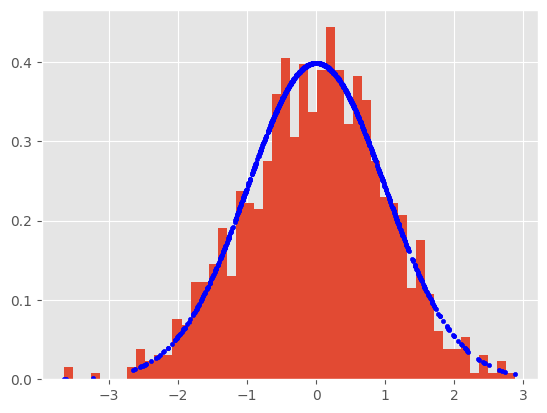

In [56]:
counts, bins = np.histogram(r,50,density=True)
plt.hist(bins[:-1], bins, weights=counts)
plt.scatter(r, probabilities, c='b', marker='.')

In [57]:
def read_data(filename):
    f = open(filename, 'r')
    p = re.compile(',')
    xdata = []
    ydata = []
    header = f.readline().strip()
    varnames = p.split(header)
    namehash = {}
    for l in f:
        li = p.split(l.strip())
        xdata.append([float(x) for x in li[:-1]])
        ydata.append(float(li[-1]))

    return np.array(xdata), np.array(ydata)


**Assuming** our data is x is available in numpy we use numpy to implement logistic regression


In [58]:
(xtrain_whole, ytrain_whole) = read_data(path + 'spambase-train.csv')
(xtest, ytest) = read_data(path + 'spambase-test.csv')

In [59]:
print("The shape of xtrain:", xtrain_whole.shape)
print("The shape of ytrain:", ytrain_whole.shape)
print("The shape of xtest:", xtest.shape)
print("The shape of ytest:", ytest.shape)

The shape of xtrain: (3601, 54)
The shape of ytrain: (3601,)
The shape of xtest: (1000, 54)
The shape of ytest: (1000,)


before training we normalize the input data (features)

In [60]:
xmean = np.mean(xtrain_whole, axis=0)
xstd = np.std(xtrain_whole, axis=0)
xtrain_normal_whole = (xtrain_whole-xmean) / xstd
xtest_normal = (xtest-xmean) / xstd

We need to create a validation set. We create an array of indecies and permute it.

In [61]:
premute_indicies = np.random.permutation(np.arange(xtrain_whole.shape[0]))

We keep the first 2600 data points as the training data and rest as the validation data

In [62]:
xtrain_normal = xtrain_normal_whole[premute_indicies[:2600]]
ytrain = ytrain_whole[premute_indicies[:2600]]
xval_normal = xtrain_normal_whole[premute_indicies[2600:]]
yval = ytrain_whole[premute_indicies[2600:]]

Initiallizing the weights and bias with random values from N(0,1)

In [63]:
weights = np.random.normal(0, 1, xtrain_normal.shape[1]);
bias = np.random.normal(0,1,1)

In [64]:
#the sigmoid function
def sigmoid(v):
    #return np.exp(-np.logaddexp(0, -v)) #numerically stable implementation of sigmoid function
    return 1.0 / (1+np.exp(-v))

We can use dot-product from numpy to calculate the margin and pass it to the sigmoid function

In [65]:
#w: weight vector (numpy array of size n)
#b: numpy array of size 1
#returns p(y=1|x, w, b)
def prob(x, w, b):
    return sigmoid(np.dot(x,w) + b);

You can also calculate $l_2$ penalty using linalg library of numpy

In [66]:
np.linalg.norm(weights)

6.44147033142516

$$\text{Cross Entropy Loss} = -\frac{1}{|D|}[\sum_{(y^i,\mathbf{x}^i)\in\mathcal{D}}
 y^i \log p(y=1|\mathbf{x}^i;\mathbf{w},b)  +  (1-y^i) \log (1 - p(y=1|\mathbf{x}^i;\mathbf{w},b))]+\frac{\lambda}{2} \|\mathbf{w}\|^2 $$

In [67]:
#w: weight vector (numpy array of size n)
#x: training data points (only attributes)
#y_prob: p(y|x, w, b)
#y_true: class variable data
#lambda_: l2 penalty coefficient
#returns the cross entropy loss
def loss(w, x, y_prob, y_true, lambda_):
    m = y_true.shape[0]

    ce_loss = -np.sum(y_true * np.log(y_prob + 1e-15) + (1 - y_true) * np.log(1 - y_prob + 1e-15)) / m

    l2_reg = (lambda_ / 2) * np.sum(w ** 2)

    return ce_loss + l2_reg


In [68]:
#x: input variables (data of size m x n with m data point and n features)
#w: weight vector (numpy array of size n)
#y_prob: p(y|x, w, b)
#y_true: class variable data
#lambda_: l2 penalty coefficient
#returns tuple of gradient w.r.t w and w.r.t to bias

def grad_w_b(x, w, y_prob, y_true, lambda_):

    m = y_true.shape[0]

    grad_w = (np.dot(x.T, (y_prob - y_true)) / m) + (lambda_ * w)

    grad_b = np.sum(y_prob - y_true) / m

    return (grad_w, grad_b)

In [69]:

#lambda_ is the coeffienct of l2 norm penalty
#learning_rate is learning rate of gradient descent algorithm
#max_iter determines the maximum number of iterations if the gradients descent does not converge.
#continue the training while gradient > 0.1 or the number steps is less max_iter

#returns model as tuple of (weights,bias)

def fit(x, y_true, learning_rate, lambda_, max_iter, verbose=0):
    weights = np.random.normal(0, 1, x.shape[1]);
    bias = np.random.normal(0,1,1)
    # raise NotImplementedError
    # #change the condition appropriately
    # while True:

    #     if verbose: #verbose is used for debugging purposes
    #         #print iteration number, loss, l2 norm of gradients, l2 norm of weights
    #         pass
    # return (weights, bias)

    for i in range(max_iter):
      y_prob = prob(x, weights, bias)

      grad_w, grad_b = grad_w_b(x, weights, y_prob, y_true, lambda_)

      grad_norm = np.linalg.norm(grad_w) + abs(grad_b)

      # Update weights and bias
      weights -= learning_rate * grad_w
      bias -= learning_rate * grad_b

      if verbose:
          loss_value = loss(weights, x, y_prob, y_true, lambda_)
          weight_norm = np.linalg.norm(weights)
          print(f"Iteration {i+1}: Loss = {loss_value:.4f}, ||Grad|| = {grad_norm:.4f}, ||W|| = {weight_norm:.4f}")

      # Stop
      if grad_norm < 0.1:
          break

    return weights, bias

In [70]:
def accuracy(x, y_true, model):
    w, b = model
    return np.sum((prob(x, w, b)>0.5).astype(float) == y_true)  / y_true.shape[0]

In [71]:
learning_rate = 0.001
lambda_ = 1.0

model = fit(xtrain_normal, ytrain, learning_rate, lambda_, 10000, verbose=1) #keep the verbose on here for your submissions

Iteration 1: Loss = 32.0634, ||Grad|| = 8.0214, ||W|| = 7.8146
Iteration 2: Loss = 31.9993, ||Grad|| = 8.0134, ||W|| = 7.8066
Iteration 3: Loss = 31.9353, ||Grad|| = 8.0053, ||W|| = 7.7986
Iteration 4: Loss = 31.8714, ||Grad|| = 7.9973, ||W|| = 7.7906
Iteration 5: Loss = 31.8076, ||Grad|| = 7.9893, ||W|| = 7.7827
Iteration 6: Loss = 31.7440, ||Grad|| = 7.9813, ||W|| = 7.7747
Iteration 7: Loss = 31.6805, ||Grad|| = 7.9734, ||W|| = 7.7667
Iteration 8: Loss = 31.6172, ||Grad|| = 7.9654, ||W|| = 7.7588
Iteration 9: Loss = 31.5539, ||Grad|| = 7.9574, ||W|| = 7.7509
Iteration 10: Loss = 31.4908, ||Grad|| = 7.9495, ||W|| = 7.7429
Iteration 11: Loss = 31.4279, ||Grad|| = 7.9415, ||W|| = 7.7350
Iteration 12: Loss = 31.3650, ||Grad|| = 7.9336, ||W|| = 7.7271
Iteration 13: Loss = 31.3023, ||Grad|| = 7.9257, ||W|| = 7.7192
Iteration 14: Loss = 31.2397, ||Grad|| = 7.9177, ||W|| = 7.7113
Iteration 15: Loss = 31.1772, ||Grad|| = 7.9098, ||W|| = 7.7034
Iteration 16: Loss = 31.1148, ||Grad|| = 7.9019, 

In [72]:
print("Train accuracy: ", accuracy(xtrain_normal, ytrain, model))

Train accuracy:  0.8476923076923077


In [73]:
#grid search for finding the best hyperparams and model

best_model = None
best_val = -1
for lr in [1,0.1,0.01, 0.001, 0.0001]:
    for la in [5,4,3, 2,1 ,0.3 ,0.2 , 0.15 , 0.05 , 0.025 , 0.02]:
        model = fit(xtrain_normal, ytrain, lr, la, 15000, verbose=0)
        val_acc = accuracy(xval_normal, yval, model)
        print(lr, la, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_model = model


<ipython-input-64-8e0f850aa7f3>:4: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1+np.exp(-v))
<ipython-input-68-4ab4a9d7ede4>:12: RuntimeWarning: overflow encountered in multiply
  grad_w = (np.dot(x.T, (y_prob - y_true)) / m) + (lambda_ * w)


1 5 0.6093906093906094
1 4 0.6093906093906094
1 3 0.6093906093906094
1 2 0.1918081918081918
1 1 0.48951048951048953
1 0.3 0.9110889110889111
1 0.2 0.9170829170829171
1 0.15 0.9180819180819181
1 0.05 0.916083916083916
1 0.025 0.9270729270729271
1 0.02 0.916083916083916
0.1 5 0.8481518481518482
0.1 4 0.6813186813186813
0.1 3 0.8841158841158842
0.1 2 0.8891108891108891
0.1 1 0.8681318681318682
0.1 0.3 0.9050949050949051
0.1 0.2 0.9100899100899101
0.1 0.15 0.919080919080919
0.1 0.05 0.919080919080919
0.1 0.025 0.9050949050949051
0.1 0.02 0.9150849150849151
0.01 5 0.6553446553446554
0.01 4 0.8781218781218781
0.01 3 0.7162837162837162
0.01 2 0.8701298701298701
0.01 1 0.8951048951048951
0.01 0.3 0.8931068931068931
0.01 0.2 0.9150849150849151
0.01 0.15 0.9170829170829171
0.01 0.05 0.9150849150849151
0.01 0.025 0.9090909090909091
0.01 0.02 0.913086913086913
0.001 5 0.7182817182817183
0.001 4 0.8771228771228772
0.001 3 0.7072927072927073
0.001 2 0.8061938061938062
0.001 1 0.8921078921078921
0.00

In [74]:
print("Test accuracy: ", accuracy(xtest_normal, ytest, best_model))

Test accuracy:  0.941
